# Genome coverage

In [1]:
from collections import defaultdict

# Parses output of bedtools genomecov -d

fpath = '/storage/NFS/ANALYSIS/DNAseq/BAM_coverage/p_fal_BMGF-Fidock-8149R1-B2_p.genomecov.txt'
f = open(fpath, 'r')

chrom_pos_cov_dict = defaultdict(dict)
for line in f:
    items = line.strip().split('\t')
    chrom = items[0]; pos = int(items[1]); coverage = int(items[2])
    chrom_pos_cov_dict[chrom][pos] = coverage

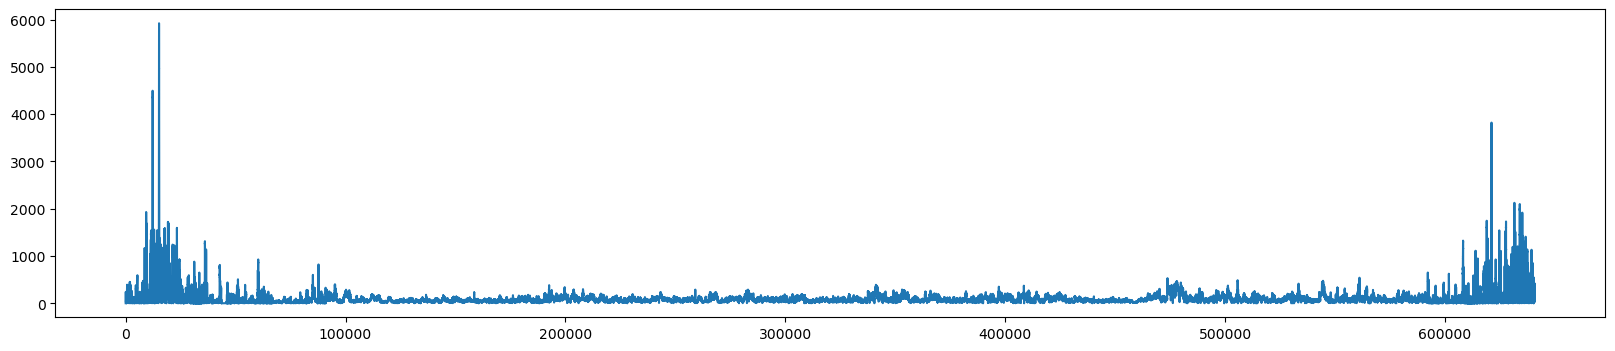

In [2]:
chrom = 'Pf3D7_01_v3'

pos_list = sorted(chrom_pos_cov_dict[chrom])
cov_list = [chrom_pos_cov_dict[chrom][pos] for pos in pos_list]

from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(pos_list, cov_list)

# Compare VCFs

In [2]:
from collections import defaultdict
import pandas as pd
import os
import pickle
from tqdm import tqdm
from urllib.parse import unquote

In [51]:
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
matplotlib.rcParams["figure.dpi"] = 300

In [4]:
# ============================
# Load gene information
# ============================

gff_fpath = "/storage/NFS/GENOME_RESOURCES/pf/p_fal_ref/p_fal.gff"

chromosomes = []
for line in open(gff_fpath, 'r'):
    if line[0] != '#':
        break
    if line[:17] == '##sequence-region':
        chromosomes.append(line.strip().split()[1])

nuclear_chromosomes = sorted(chromosomes[2:])
chrom_gene_exon_interval_dict = {chrom: defaultdict(dict) for chrom in chromosomes} # chrom -> gene ID -> exon ID -> (start, end, strand_direction)

chrom_gene_ids_dict = {chrom: set() for chrom in chromosomes} # All protein coding gene IDs
chrom_gene_desc_dict = {chrom: {} for chrom in chromosomes} # gene_id -> description
chrom_gene_interval_dict = {chrom: {} for chrom in chromosomes} # gene_id -> (start, end, strand_direction)

for line in open(gff_fpath, 'r'):
    if line.strip() == '##FASTA':
        break
    if line[0] == '#':
        continue
    chrom, source, feature_type, start_pos, end_pos, _, sdirection, _, info = line.strip().split('\t')
    start_pos = int(start_pos); end_pos = int(end_pos)
    if feature_type == 'exon':
        exon_id = info.split(';')[0].split('ID=')[1]
        gene_id = exon_id.split('exon_')[1].split('-')[0]
        chrom_gene_exon_interval_dict[chrom][gene_id][exon_id] = (start_pos, end_pos, sdirection)
    if feature_type == 'gene':
        gene_id = info.split(';')[0].split('ID=')[1]
        gene_desc = info.split(';')[2].split('description=')[1]
        chrom_gene_desc_dict[chrom][gene_id] = unquote(gene_desc.strip()).replace('+', ' ')
        chrom_gene_interval_dict[chrom][gene_id] = (start_pos, end_pos, sdirection)
    if feature_type == 'CDS': # Actually coding
        gene_id = info.split(';')[0].split('ID=')[1].split('cds_')[1].split('-')[0]
        if gene_id != 'PF3D7_0112400' and 'pseudogene' not in chrom_gene_desc_dict[chrom][gene_id]: # Ignore pseudogenes
            chrom_gene_ids_dict[chrom].add(gene_id)

total_num_coding_genes = sum([len(chrom_gene_ids_dict[chrom]) for chrom in chromosomes])
alt_order_chromosomes = ['Pf3D7_01_v3', 'Pf3D7_06_v3', 'Pf3D7_11_v3', 'Pf3D7_02_v3', 'Pf3D7_07_v3', 'Pf3D7_12_v3', 
                         'Pf3D7_03_v3', 'Pf3D7_08_v3', 'Pf3D7_13_v3', 'Pf3D7_04_v3', 'Pf3D7_09_v3', 'Pf3D7_14_v3', 
                         'Pf3D7_05_v3', 'Pf3D7_10_v3', 'M76611', 'PFC10_API_IRAB']
for chrom_i in range(0, len(alt_order_chromosomes[:-2]), 3):
    print("\t".join(["%s\t%i" % (chrom, len(chrom_gene_ids_dict[chrom])) for chrom in alt_order_chromosomes[chrom_i:chrom_i+3]]))
print('\n' + "\t".join(["%s\t%i" % (chrom, len(chrom_gene_ids_dict[chrom])) for chrom in ['M76611', 'PFC10_API_IRAB']]) + '\n')
print("Total number of protein coding genes: %i" % total_num_coding_genes)

Pf3D7_01_v3	135	Pf3D7_06_v3	320	Pf3D7_11_v3	485
Pf3D7_02_v3	223	Pf3D7_07_v3	295	Pf3D7_12_v3	531
Pf3D7_03_v3	243	Pf3D7_08_v3	317	Pf3D7_13_v3	699
Pf3D7_04_v3	235	Pf3D7_09_v3	383	Pf3D7_14_v3	775
Pf3D7_05_v3	312	Pf3D7_10_v3	414	M76611	3

M76611	3	PFC10_API_IRAB	30

Total number of protein coding genes: 5400


In [5]:
def get_format_data_dict(FORMAT, data):
    return {key: val for key, val in zip(FORMAT.split(':'), data.split(':'))}

In [6]:
vcf_dir = '/storage/NFS/ANALYSIS/DNAseq/VCF_ann'
vcf = 'p_fal_Fidock-Dd2Parent_p_Unfiltered.vcf'
f = open('%s/%s.ann.txt' % (vcf_dir, vcf))

for line in f:
    if line.startswith('#CHROM'):
        header_items = line.strip().split('\t')
        break    

mutation_records = []

for line in f:
    items = line.strip().split('\t')
    CHROM, POS, ID, REF, ALT, QUAL, FILTER, INFO, FORMAT = items[:9]; POS = int(POS)

    if QUAL == '.' or float(QUAL) < 500:
        continue

    # Allele annotations
    first_alt_allele = ALT.split(',')[0]
    pre_eff = INFO.split(';EFF=')[0]
    eff = INFO.split(';EFF=')[1].split(';')[0]

    allele_anno_dict = {}
    for anno in eff.split(','):
        last = anno.split('|')[-1]
        if 'INFO_' in last or 'WARNING_' in last or 'ERROR_' in last:
            alt_allele = anno.split('|')[-2].split(')')[0]
        else:
            alt_allele = anno.split('|')[-1].split(')')[0]
        effect, rest = anno.split('(')
        impact, codon_change, aa_change, _, gene = rest.split('|')[1:6]
        vtype = 'SNP' if (REF in ['A', 'C', 'G', 'T'] and alt_allele in ['A', 'C', 'G', 'T']) else 'INDEL'
        allele_anno_dict[alt_allele] = (vtype, effect, impact, codon_change, aa_change, gene)

    data = items[9]
    data_dict = get_format_data_dict(FORMAT, data)
    GT = data_dict['GT']; AD = data_dict['AD']
    
    major_alt_allele = ALT.split(',')[0]; major_alt_allele_depth = -1
    for i, depth in enumerate(AD.split(',')[1:]):
        if int(depth) > major_alt_allele_depth:
            major_alt_allele_depth = int(depth)
            major_alt_allele = ALT.split(',')[i]
    
    vtype, effect, impact, codon_change, aa_change, gene = allele_anno_dict[major_alt_allele]
    
    if impact != 'MISSENSE':
        continue
    
    # items = [CHROM, POS, REF, ALT, QUAL, GT, AD, vtype, effect, impact, codon_change, aa_change, gene]
    items = [gene, aa_change.split('/')[0].split('p.')[1], chrom_gene_desc_dict[CHROM][gene]]
    print('\t'.join([str(item) for item in items]))

PF3D7_0400100	Glu367Asp	erythrocyte membrane protein 1, PfEMP1 (VAR)
PF3D7_0400100	Lys378Glu	erythrocyte membrane protein 1, PfEMP1 (VAR)
PF3D7_0400100	Asn379Lys	erythrocyte membrane protein 1, PfEMP1 (VAR)
PF3D7_0400100	Val386Asp	erythrocyte membrane protein 1, PfEMP1 (VAR)
PF3D7_0400100	Asp390Glu	erythrocyte membrane protein 1, PfEMP1 (VAR)
PF3D7_0400100	Phe391Val	erythrocyte membrane protein 1, PfEMP1 (VAR)
PF3D7_0400100	Phe391Tyr	erythrocyte membrane protein 1, PfEMP1 (VAR)
PF3D7_0400100	Asp392Val	erythrocyte membrane protein 1, PfEMP1 (VAR)
PF3D7_0400100	Pro402Arg	erythrocyte membrane protein 1, PfEMP1 (VAR)
PF3D7_0400100	Asp405Asn	erythrocyte membrane protein 1, PfEMP1 (VAR)
PF3D7_0400100	Gln566Lys	erythrocyte membrane protein 1, PfEMP1 (VAR)
PF3D7_0400100	Glu922Gln	erythrocyte membrane protein 1, PfEMP1 (VAR)
PF3D7_0400100	Lys924Glu	erythrocyte membrane protein 1, PfEMP1 (VAR)
PF3D7_0400100	Glu927Lys	erythrocyte membrane protein 1, PfEMP1 (VAR)
PF3D7_0400100	Gln929Glu	erythrocyt

PF3D7_0113600	Tyr1245His	surface-associated interspersed protein 1.2 (SURFIN 1.2), pseudogene (SURF1.2)
PF3D7_0113600	Thr1289Met	surface-associated interspersed protein 1.2 (SURFIN 1.2), pseudogene (SURF1.2)
PF3D7_0113600	Asn1321Lys	surface-associated interspersed protein 1.2 (SURFIN 1.2), pseudogene (SURF1.2)
PF3D7_0113600	Gln1373Glu	surface-associated interspersed protein 1.2 (SURFIN 1.2), pseudogene (SURF1.2)
PF3D7_0113600	Lys1380Asn	surface-associated interspersed protein 1.2 (SURFIN 1.2), pseudogene (SURF1.2)
PF3D7_0113600	Ile1681Leu	surface-associated interspersed protein 1.2 (SURFIN 1.2), pseudogene (SURF1.2)
PF3D7_0113600	Ter1724Tyrext*?	surface-associated interspersed protein 1.2 (SURFIN 1.2), pseudogene (SURF1.2)
PF3D7_0113600	Ser1815Asn	surface-associated interspersed protein 1.2 (SURFIN 1.2), pseudogene (SURF1.2)
PF3D7_0113700	Ser401Ile	heat shock protein 40, type II (HSP40)
PF3D7_0113700	Ser401Arg	heat shock protein 40, type II (HSP40)
PF3D7_0113800	Ser107Gly	DBL containin

PF3D7_1009200	Cys207Tyr	small subunit rRNA synthesis-associated protein, putative
PF3D7_1009200	Gln842His	small subunit rRNA synthesis-associated protein, putative
PF3D7_1009200	Gln912His	small subunit rRNA synthesis-associated protein, putative
PF3D7_1009300	Met314Arg	conserved Plasmodium protein, unknown function
PF3D7_1009600	Asp106Val	protein phosphatase, putative
PF3D7_1009800	Ile327Met	conserved Plasmodium membrane protein, unknown function
PF3D7_1010200	Glu555Asp	DNA2/NAM7 helicase, putative
PF3D7_1010400	Asn131Lys	conserved Plasmodium protein, unknown function
PF3D7_1010900	Glu112Gly	conserved Plasmodium protein, unknown function
PF3D7_1011500	Ile113Thr	conserved Plasmodium membrane protein, unknown function
PF3D7_1012500	Ile395Leu	phosphoglucomutase, putative
PF3D7_1012500	Cys61Gly	phosphoglucomutase, putative
PF3D7_1012700	Asn165Ser	NLI interacting factor-like phosphatase, putative (NIF4)
PF3D7_1012700	Tyr1133Asn	NLI interacting factor-like phosphatase, putative (NIF4)
PF3D7_

In [7]:
f = open('/storage/NFS/ANALYSIS/DNAseq/PfResistome_2023/daisy_test/Sequenced_Clone_Metadata_10-17-2023_v2.txt', 'r')
header = f.readline().rstrip('\n')

clone_vcf_dict = defaultdict(dict) # strain -> sample -> vcf

for line in f:
    _, _, lab, strain, compound, alias, sample, parent, _, target, driver, \
    vcf, _, _, parent_vcf, parent_in_same_vcf = line.rstrip('\n').split('\t')[:16]
    
    clone_vcf_dict[sample] = vcf

In [8]:
def get_possible_variants(focal_sample):
    vcf_dir = '/storage/NFS/ANALYSIS/DNAseq/VCF_ann'
    vcf = clone_vcf_dict[focal_sample]
    f = open('%s/%s.ann.txt' % (vcf_dir, vcf))
    
    for line in f:
        if line.startswith('#CHROM'):
            header_items = line.strip().split('\t')
            break    
    
    mutation_records = []
    
    for line in f:
        items = line.strip().split('\t')
        CHROM, POS, ID, REF, ALT, QUAL, FILTER, INFO, FORMAT = items[:9]; POS = int(POS)

        if QUAL == '.' or float(QUAL) < 500:
            continue
        
        # Allele annotations
        first_alt_allele = ALT.split(',')[0]
        pre_eff = INFO.split(';EFF=')[0]
        eff = INFO.split(';EFF=')[1].split(';')[0]
        
        allele_anno_dict = {}
        for anno in eff.split(','):
            last = anno.split('|')[-1]
            if 'INFO_' in last or 'WARNING_' in last or 'ERROR_' in last:
                alt_allele = anno.split('|')[-2].split(')')[0]
            else:
                alt_allele = anno.split('|')[-1].split(')')[0]
            effect, rest = anno.split('(')
            impact, codon_change, aa_change, _, gene = rest.split('|')[1:6]
            vtype = 'SNP' if (REF in ['A', 'C', 'G', 'T'] and alt_allele in ['A', 'C', 'G', 'T']) else 'INDEL'
            allele_anno_dict[alt_allele] = (vtype, effect, impact, codon_change, aa_change, gene)
        
        for idx in range(9, len(items)):
            
            sample = header_items[idx]
            if sample != focal_sample:
                continue
            
            parent_sample = clone_parent_dict[sample]
            if parent_sample == "IS_PARENT":
                continue
            
            parent_data = items[header_items.index(parent_sample)]
            parent_data_dict = get_format_data_dict(FORMAT, parent_data)
            
            if parent_data_dict['GT'] == './.' or 'DP' not in parent_data_dict or \
               parent_data_dict['DP'] == '.' or int(parent_data_dict['DP']) < 7:
                continue
            
            data = items[idx]
            data_dict = get_format_data_dict(FORMAT, data)
            
            if 'DP' not in data_dict or data_dict['DP'] == '.' or int(data_dict['DP']) < 7:
                continue
            
            GT = data_dict['GT']; AD = data_dict['AD']
            
            major_alt_allele = first_alt_allele; major_alt_allele_depth = -1
            for i, depth in enumerate(AD.split(',')[1:]):
                if int(depth) > major_alt_allele_depth:
                    major_alt_allele_depth = int(depth)
                    major_alt_allele = ALT.split(',')[i]
            
            vtype, effect, impact, codon_change, aa_change, gene = allele_anno_dict[major_alt_allele]
            
            if parent_data_dict['GT'] == '0/0' and data_dict['GT'] != '0/0':
                mutation_records.append((CHROM, POS, REF, ALT, QUAL, GT, AD, parent_data_dict['GT'], parent_data_dict['AD']))
            elif parent_data_dict['GT'] != '0/0' and data_dict['GT'] == '0/0':
                mutation_records.append((CHROM, POS, REF, ALT, QUAL, GT, AD, parent_data_dict['GT'], parent_data_dict['AD']))
    
    return mutation_records

In [9]:
def get_all_variants(focal_sample, quality_threshold=500, depth_threshold=7):
    vcf_dir = '/storage/NFS/ANALYSIS/DNAseq/VCF_ann'
    vcf = clone_vcf_dict[focal_sample]
    f = open('%s/%s.ann.txt' % (vcf_dir, vcf))
    
    for line in f:
        if line.startswith('#CHROM'):
            header_items = line.strip().split('\t')
            break    
    
    chrom_pos_mutation_dict = defaultdict(dict)
    
    for line in f:
        items = line.strip().split('\t')
        CHROM, POS, ID, REF, ALT, QUAL, FILTER, INFO, FORMAT = items[:9]; POS = int(POS)

        if QUAL == '.' or float(QUAL) < quality_threshold:
            continue
        
        # Allele annotations
        first_alt_allele = ALT.split(',')[0]
        pre_eff = INFO.split(';EFF=')[0]
        eff = INFO.split(';EFF=')[1].split(';')[0]
        
        allele_anno_dict = {}
        for anno in eff.split(','):
            last = anno.split('|')[-1]
            if 'INFO_' in last or 'WARNING_' in last or 'ERROR_' in last:
                alt_allele = anno.split('|')[-2].split(')')[0]
            else:
                alt_allele = anno.split('|')[-1].split(')')[0]
            effect, rest = anno.split('(')
            impact, codon_change, aa_change, _, gene = rest.split('|')[1:6]
            vtype = 'SNP' if (REF in ['A', 'C', 'G', 'T'] and alt_allele in ['A', 'C', 'G', 'T']) else 'INDEL'
            allele_anno_dict[alt_allele] = (vtype, effect, impact, codon_change, aa_change, gene)
        
        for idx in range(9, len(items)):
            
            sample = header_items[idx]
            data = items[idx]; data_dict = get_format_data_dict(FORMAT, data)
            
            if data_dict['GT'] == './.' or 'DP' not in data_dict or \
               data_dict['DP'] == '.' or int(data_dict['DP']) < depth_threshold:
                continue
            
            GT = data_dict['GT']; AD = data_dict['AD']
            
            major_alt_allele = first_alt_allele; major_alt_allele_depth = -1
            for i, depth in enumerate(AD.split(',')[1:]):
                if int(depth) > major_alt_allele_depth:
                    major_alt_allele_depth = int(depth)
                    major_alt_allele = ALT.split(',')[i]
            
            if major_alt_allele == '*': # Spanning deletion (ignore since deletion previously accounted for)
                continue
            
            vtype, effect, impact, codon_change, aa_change, gene = allele_anno_dict[major_alt_allele]
            
            chrom_pos_mutation_dict[CHROM][POS] = (REF, ALT, QUAL, GT, AD, major_alt_allele, vtype, effect, impact, aa_change, gene)
    
    return chrom_pos_mutation_dict

# Determine strain

In [10]:
f = open('/storage/NFS/ANALYSIS/DNAseq/PfResistome_2023/daisy_test/Sequenced_Clone_Metadata_10-17-2023_v2.txt', 'r')
header = f.readline().rstrip('\n')

strain_parent_vcfs = defaultdict(dict) # strain -> sample -> vcf

for line in f:
    _, _, lab, strain, compound, alias, sample, parent, _, target, driver, \
    vcf, _, _, parent_vcf, parent_in_same_vcf = line.rstrip('\n').split('\t')[:16]
    
    if sample == 'GSK-Dd2F-397-Parent': # Mistake
        strain = 'Dd2'
    
    if parent == 'IS_PARENT':
        strain_parent_vcfs[strain][sample] = vcf

In [13]:
def chrom_to_abbreviation(chrom):
    if chrom.startswith("Pf3D7"):
        return chrom.split("Pf3D7_")[1].split('_')[0]
    elif "API" in chrom:
        return "API"
    elif chrom == 'M76611':
        return 'MT' # Mitochondrial genome

In [68]:
# Function to get how many times alt alleles are shared in a group of samples

def compute_allele_sharing_dict(sample_mutation_records_dict, samples=None):
    if samples is None:
        samples = sample_mutation_records_dict.keys()
    
    chrom_pos_allele_sharing_dict = {chrom: defaultdict(int) for chrom in chromosomes} # chrom -> (pos, allele)-> number of samples (major)
    chrom_pos_allele_anno_dict = defaultdict(dict) # chrom -> (pos, allele) -> (vtype, effect, impact, aa_change, gene)
    for sample in samples:
        for chrom in sample_mutation_records_dict[sample]:
            for pos in sample_mutation_records_dict[sample][chrom]:
                REF, ALT, QUAL, GT, AD, major_alt_allele, \
                vtype, effect, impact, aa_change, gene = sample_mutation_records_dict[sample][chrom][pos]
                if not GT.startswith('0/'):
                    chrom_pos_allele_sharing_dict[chrom][(pos, major_alt_allele)] += 1
                    chrom_pos_allele_anno_dict[chrom][(pos, major_alt_allele)] = (vtype, effect, impact, aa_change, gene)
    
    return chrom_pos_allele_sharing_dict, chrom_pos_allele_anno_dict

## Characterize 3D7 parents

In [90]:
# Firstly investigate 3D7
parent3D7_mutation_records_dict = {}
for sample in strain_parent_vcfs['3D7']:
    try:
        mutation_records = get_all_variants(sample)
        parent3D7_mutation_records_dict[sample] = mutation_records
    except:
        continue

print(len(parent3D7_mutation_records_dict))

50


In [91]:
# Distribution of number of alt alleles per chromosome
# Start with non-het mutations (1/1, 1/2, etc.)

chrom_alt_count_dict = defaultdict(list)
ordered_samples = sorted(parent3D7_mutation_records_dict.keys())
genome_alt_counts = np.zeros(len(ordered_samples))

for chrom in chromosomes:
    for idx, sample in enumerate(ordered_samples):
        num_confident_alt_alleles = 0
        for pos in parent3D7_mutation_records_dict[sample][chrom]:
            REF, ALT, QUAL, GT, AD, major_alt_allele, vtype, effect, impact, aa_change, gene \
                = parent3D7_mutation_records_dict[sample][chrom][pos]
            if not GT.startswith('0/'):
                num_confident_alt_alleles += 1
        chrom_alt_count_dict[chrom].append(num_confident_alt_alleles)
        genome_alt_counts[idx] += num_confident_alt_alleles

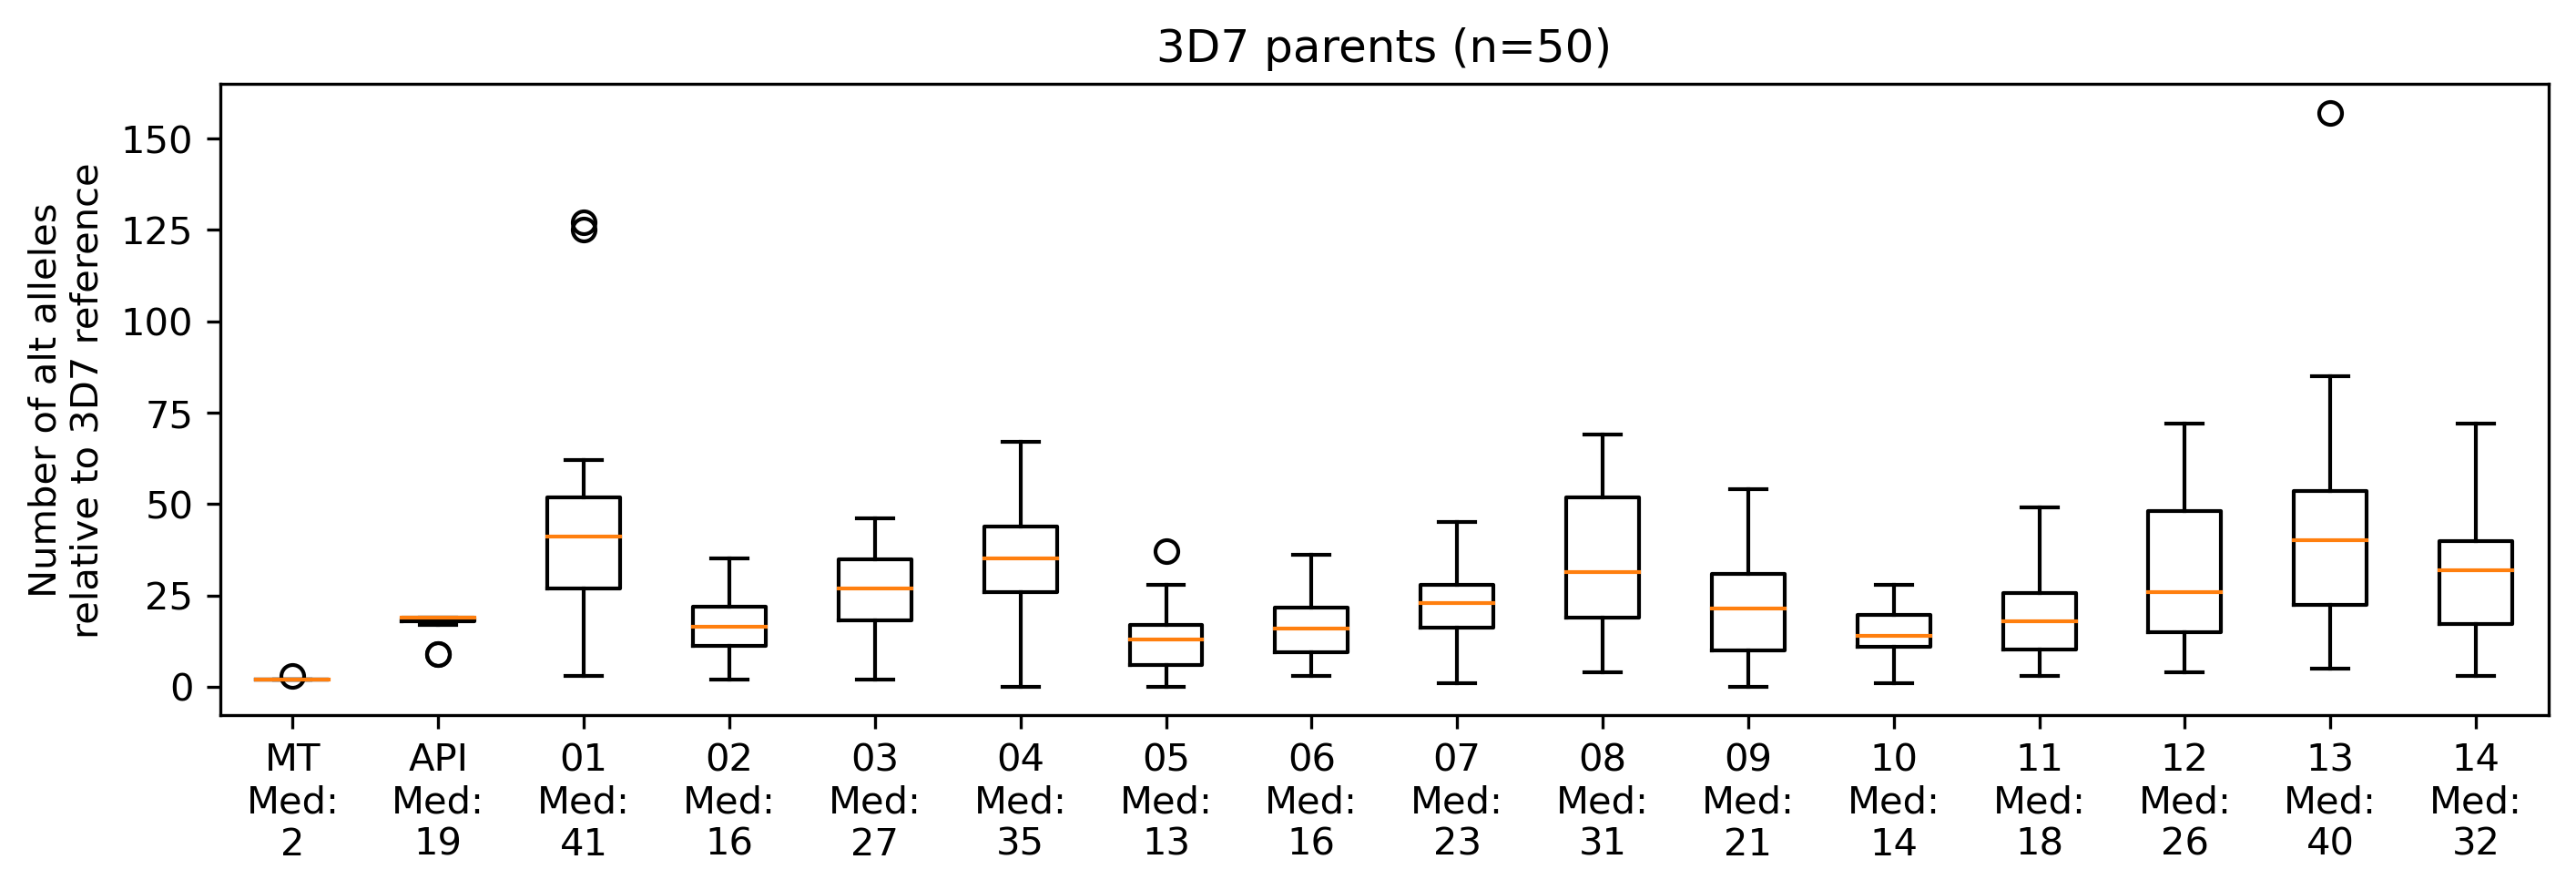

Median number confident alt alleles genome-wide: 376
59 727


In [92]:
fig, ax = plt.subplots(figsize=(11, 3))

boxplot_data = []
labels = []

for i in range(len(chromosomes)):
    chrom = chromosomes[i]
    chrom_abbr = chrom_to_abbreviation(chrom)
    boxplot_data.append(chrom_alt_count_dict[chrom])
    labels.append(chrom_abbr + '\n' + f"Med:\n{int(np.median(chrom_alt_count_dict[chrom]))}")

ax.boxplot(boxplot_data, vert=True, labels=labels)
ax.set_title("3D7 parents (n=%i)" % len(ordered_samples))
ax.set_ylabel("Number of alt alleles\nrelative to 3D7 reference")
plt.show()

print("Median number confident alt alleles genome-wide: %i" % int(np.median(genome_alt_counts)))
print(int(min(genome_alt_counts)), int(max(genome_alt_counts)))

In [42]:
# Common missense SNPs
parent3D7_allele_sharing_dict, parent3D7_allele_anno_dict = compute_allele_sharing_dict(parent3D7_mutation_records_dict)
for chrom in parent3D7_allele_sharing_dict:
    print(chrom)
    for mutation, count in sorted(parent3D7_allele_sharing_dict[chrom].items(), key=lambda x: x[1], reverse=True):
        vtype, effect, impact, aa_change, gene = parent3D7_allele_anno_dict[chrom][mutation]
        gene_desc = chrom_gene_desc_dict[chrom][gene] if gene in chrom_gene_desc_dict[chrom] else gene
        pos, allele = mutation
        if count/float(len(parent3D7_mutation_records_dict)) > 0.2:
            if vtype == 'SNP' and effect == 'missense_variant':
                items = [count, vtype, mutation, effect, aa_change, gene_desc]
                print('\t'.join([str(item) for item in items]))
    print('')

M76611
50	SNP	(772, 'C')	missense_variant	p.Ile239Val/c.715A>G	cytochrome c oxidase subunit 3 (COX3)

PFC10_API_IRAB
50	SNP	(18828, 'T')	missense_variant	p.Gln15Lys/c.43C>A	probably protein, unknown function (ORF129)
50	SNP	(18860, 'A')	missense_variant	p.Ser4Leu/c.11C>T	probably protein, unknown function (ORF129)
50	SNP	(22669, 'T')	missense_variant	p.Arg118Lys/c.353G>A	apicoplast ribosomal protein S5 (rps5)
50	SNP	(29000, 'T')	missense_variant	p.Cys31Tyr/c.92G>A	apicoplast ribosomal protein S4 (rps4)
50	SNP	(29019, 'T')	missense_variant	p.Gly25Ser/c.73G>A	apicoplast ribosomal protein S4 (rps4)
49	SNP	(23796, 'C')	missense_variant	p.Ile46Val/c.136A>G	apicoplast ribosomal protein S8 (rps8)

Pf3D7_01_v3

Pf3D7_02_v3

Pf3D7_03_v3

Pf3D7_04_v3

Pf3D7_05_v3
23	SNP	(871339, 'T')	missense_variant	p.Glu1078Lys/c.3232G>A	conserved Plasmodium protein, unknown function

Pf3D7_06_v3
36	SNP	(727227, 'A')	missense_variant	p.Asp1422Tyr/c.4264G>T	erythrocyte membrane protein 1, PfEMP1 (VAR)
36	SNP	(1

In [44]:
# Common other genic SNPs
parent3D7_allele_sharing_dict, parent3D7_allele_anno_dict = compute_allele_sharing_dict(parent3D7_mutation_records_dict)
for chrom in parent3D7_allele_sharing_dict:
    print(chrom)
    for mutation, count in sorted(parent3D7_allele_sharing_dict[chrom].items(), key=lambda x: x[1], reverse=True):
        vtype, effect, impact, aa_change, gene = parent3D7_allele_anno_dict[chrom][mutation]
        gene_desc = chrom_gene_desc_dict[chrom][gene] if gene in chrom_gene_desc_dict[chrom] else gene
        pos, allele = mutation
        if count/float(len(parent3D7_mutation_records_dict)) > 0.2:
            if vtype == 'SNP' and effect != 'missense_variant' and effect != "intergenic_region":
                items = [count, vtype, mutation, effect, aa_change, gene_desc]
                print('\t'.join([str(item) for item in items]))
    print('')

M76611

PFC10_API_IRAB
50	SNP	(9004, 'C')	synonymous_variant	p.Ser658Ser/c.1974T>C	RNA polymerase B (rpoB)
50	SNP	(17915, 'A')	synonymous_variant	p.Leu195Leu/c.583C>T	molecular chaperone (Clp (C?))
50	SNP	(18694, 'A')	synonymous_variant	p.Asp59Asp/c.177C>T	probably protein, unknown function (ORF129)

Pf3D7_01_v3

Pf3D7_02_v3

Pf3D7_03_v3
36	SNP	(837583, 'G')	stop_gained	p.Ser30*/c.89C>G	protein phosphatase inhibitor 2 (I2)

Pf3D7_04_v3

Pf3D7_05_v3
29	SNP	(1083232, 'A')	intron_variant	c.330-87C>T	ADP-ribosylation factor GTPase-activating protein, putative (ARF-GAP)
27	SNP	(1290902, 'A')	non_coding_exon_variant	n.1302G>A	18S ribosomal RNA

Pf3D7_06_v3

Pf3D7_07_v3
13	SNP	(375302, 'T')	intron_variant	c.2058+34T>A	conserved Plasmodium protein, unknown function
13	SNP	(375309, 'T')	intron_variant	c.2058+27T>A	conserved Plasmodium protein, unknown function
11	SNP	(234177, 'A')	synonymous_variant	p.Lys259Lys/c.777G>A	phosphopantetheine adenylyltransferase, putative (PPAT)

Pf3D7_08_v3
36	SNP

In [41]:
# Common indels
parent3D7_allele_sharing_dict, parent3D7_allele_anno_dict = compute_allele_sharing_dict(parent3D7_mutation_records_dict)
for chrom in parent3D7_allele_sharing_dict:
    print(chrom)
    for mutation, count in sorted(parent3D7_allele_sharing_dict[chrom].items(), key=lambda x: x[1], reverse=True):
        vtype, effect, impact, aa_change, gene = parent3D7_allele_anno_dict[chrom][mutation]
        gene_desc = chrom_gene_desc_dict[chrom][gene] if gene in chrom_gene_desc_dict[chrom] else gene
        pos, allele = mutation
        if count/float(len(parent3D7_mutation_records_dict)) > 0.5:
            if vtype == 'INDEL':
                items = [count, vtype, mutation, effect, aa_change, gene_desc]
                print('\t'.join([str(item) for item in items]))
    print('')

M76611

PFC10_API_IRAB
48	INDEL	(15405, 'A')	frameshift_variant	p.Leu210fs/c.628_641delTTAAAAATATGTAA	apicoplast ribosomal protein S2 (rps2)
48	INDEL	(17266, 'ATAT')	inframe_insertion	p.Asn410dup/c.1229_1231dupATA	molecular chaperone (Clp (C?))
48	INDEL	(23943, 'AT')	intergenic_region	n.23943_23944insT	
48	INDEL	(23947, 'AT')	frameshift_variant	p.Ter115fs/c.342dupA	apicoplast ribosomal protein L14 (rpl14)
48	INDEL	(25587, 'C')	intergenic_region	n.25588delT	
48	INDEL	(27761, 'T')	frameshift_variant	p.Ser4fs/c.9delT	PFC10_API0047%3AtRNA
48	INDEL	(28008, 'A')	frameshift_variant	p.Asn17fs/c.50delA	PFC10_API0050%3AtRNA
48	INDEL	(28127, 'GA')	intergenic_region	n.28127_28128insA	
44	INDEL	(25869, 'AT')	intergenic_region	n.25869_25870insT	

Pf3D7_01_v3
48	INDEL	(293766, 'G')	splice_donor_variant+splice_region_variant+intron_variant	c.124+2_124+15delTAAATAATAAATAA	centrin-1 (CEN1)
47	INDEL	(190317, 'C')	disruptive_inframe_deletion	p.Asn25_Asn26del/c.74_79delATAATA	ubiquitin carboxyl-terminal hy

## Characterize Dd2 parents

In [83]:
parentDd2_mutation_records_dict = {}
for sample in strain_parent_vcfs['Dd2']:
    if sample == 'ParentDd2' or sample == 'GSK-MMV903582-Parent23':
        continue
    try:
        mutation_records = get_all_variants(sample)
        parentDd2_mutation_records_dict[sample] = mutation_records
    except:
        continue

print(len(parentDd2_mutation_records_dict))

48


In [84]:
# Distribution of number of alt alleles per chromosome
# Start with non-het mutations (1/1, 1/2, etc.)

chrom_alt_count_dict = defaultdict(list)
ordered_samples = sorted(parentDd2_mutation_records_dict.keys())
genome_alt_counts = np.zeros(len(ordered_samples))

for chrom in chromosomes:
    for idx, sample in enumerate(ordered_samples):
        num_confident_alt_alleles = 0
        for pos in parentDd2_mutation_records_dict[sample][chrom]:
            REF, ALT, QUAL, GT, AD, major_alt_allele, vtype, effect, impact, aa_change, gene \
                = parentDd2_mutation_records_dict[sample][chrom][pos]
            if not GT.startswith('0/'):
                num_confident_alt_alleles += 1
        chrom_alt_count_dict[chrom].append(num_confident_alt_alleles)
        genome_alt_counts[idx] += num_confident_alt_alleles

for sample, genome_alt_count in zip(ordered_samples, genome_alt_counts):
    if genome_alt_count < 20000:
        print(sample, genome_alt_count)

Erika-Dd2ParentPQR 7154.0
Wirth-MMV019721-Dd2-RS2D-P1-130319Dd2 13503.0


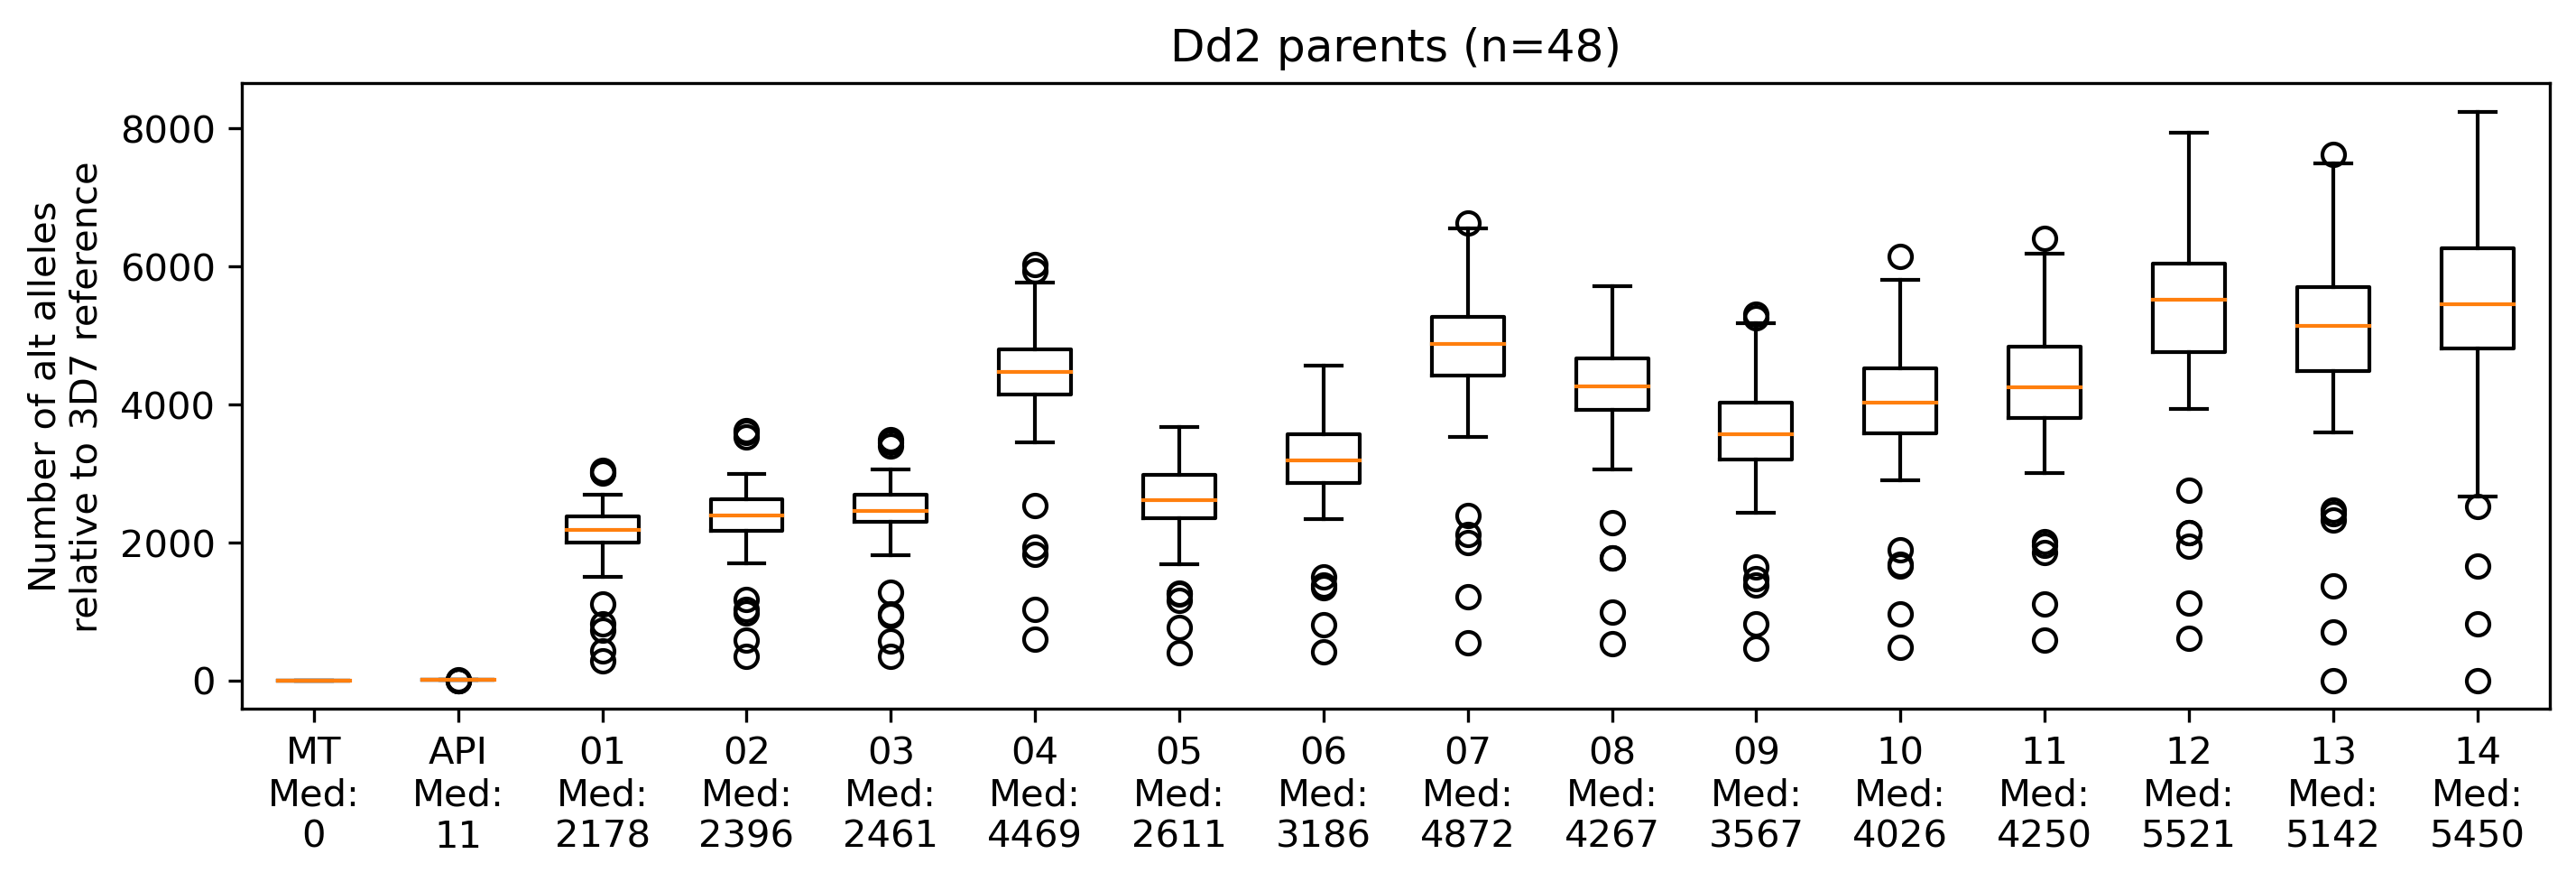

Median number confident alt alleles genome-wide: 54077
7154 78137


In [88]:
fig, ax = plt.subplots(figsize=(11, 3))

boxplot_data = []
labels = []

for i in range(len(chromosomes)):
    chrom = chromosomes[i]
    chrom_abbr = chrom_to_abbreviation(chrom)
    boxplot_data.append(chrom_alt_count_dict[chrom])
    labels.append(chrom_abbr + '\n' + f"Med:\n{int(np.median(chrom_alt_count_dict[chrom]))}")

ax.boxplot(boxplot_data, vert=True, labels=labels)
ax.set_title("Dd2 parents (n=%i)" % len(ordered_samples))
ax.set_ylabel("Number of alt alleles\nrelative to 3D7 reference")
plt.show()

print("Median number confident alt alleles genome-wide: %i" % int(np.median(genome_alt_counts)))
print(int(min(genome_alt_counts)), int(max(genome_alt_counts)))

Wonder if I do PCA, get clusters by lab...

In [89]:
# Common missense SNPs
parentDd2_allele_sharing_dict, parentDd2_allele_anno_dict = compute_allele_sharing_dict(parentDd2_mutation_records_dict)
for chrom in parentDd2_allele_sharing_dict:
    print(chrom)
    for mutation, count in sorted(parentDd2_allele_sharing_dict[chrom].items(), key=lambda x: x[1], reverse=True):
        vtype, effect, impact, aa_change, gene = parentDd2_allele_anno_dict[chrom][mutation]
        gene_desc = chrom_gene_desc_dict[chrom][gene] if gene in chrom_gene_desc_dict[chrom] else gene
        pos, allele = mutation
        if count/float(len(parentDd2_mutation_records_dict)) > 0.2:
            if vtype == 'SNP' and effect == 'missense_variant':
                items = [count, vtype, mutation, effect, aa_change, gene_desc]
                print('\t'.join([str(item) for item in items]))
    print('')

M76611

PFC10_API_IRAB
47	SNP	(29000, 'T')	missense_variant	p.Cys31Tyr/c.92G>A	apicoplast ribosomal protein S4 (rps4)
46	SNP	(18828, 'T')	missense_variant	p.Gln15Lys/c.43C>A	probably protein, unknown function (ORF129)
46	SNP	(18860, 'A')	missense_variant	p.Ser4Leu/c.11C>T	probably protein, unknown function (ORF129)

Pf3D7_01_v3
48	SNP	(54275, 'T')	missense_variant	p.Gln195Lys/c.583C>A	rifin,PIR protein (RIF)
48	SNP	(95518, 'T')	missense_variant	p.Arg156Ile/c.467G>T	stevor, pseudogene,PIR protein, pseudogene
48	SNP	(98868, 'G')	missense_variant	p.Asp17Gly/c.50A>G	ring-infected erythrocyte surface antigen (RESA)
48	SNP	(101269, 'T')	missense_variant	p.Val749Leu/c.2245G>T	ring-infected erythrocyte surface antigen (RESA)
48	SNP	(111503, 'T')	missense_variant	p.Asp1433Asn/c.4297G>A	erythrocyte binding antigen-181 (EBA181)
48	SNP	(114473, 'G')	missense_variant	p.Lys443Gln/c.1327A>C	erythrocyte binding antigen-181 (EBA181)
48	SNP	(114559, 'A')	missense_variant	p.Asn414Ile/c.1241A>T	erythrocyt

11	SNP	(98749, 'A')	missense_variant	p.Val596Met/c.1786G>A	unspecified product
11	SNP	(2029957, 'T')	missense_variant	p.Pro1381Ser/c.4141C>T	erythrocyte membrane protein 1, PfEMP1 (VAR)
11	SNP	(2029967, 'G')	missense_variant	p.Ile1384Ser/c.4151T>G	erythrocyte membrane protein 1, PfEMP1 (VAR)
11	SNP	(2029969, 'G')	missense_variant	p.His1385Asp/c.4153C>G	erythrocyte membrane protein 1, PfEMP1 (VAR)
11	SNP	(48726, 'G')	missense_variant	p.Ile131Val/c.391A>G	rifin,PIR protein (RIF)
11	SNP	(2034861, 'A')	missense_variant	p.Leu2779Ile/c.8335C>A	erythrocyte membrane protein 1, PfEMP1 (VAR)
11	SNP	(2026321, 'C')	missense_variant	p.Tyr169His/c.505T>C	erythrocyte membrane protein 1, PfEMP1 (VAR)
11	SNP	(1851662, 'C')	missense_variant	p.Asn517Ser/c.1550A>G	conserved Plasmodium protein, unknown function
11	SNP	(1851680, 'C')	missense_variant	p.Asn511Ser/c.1532A>G	conserved Plasmodium protein, unknown function
11	SNP	(2033662, 'C')	missense_variant	p.Glu2616Gln/c.7846G>C	erythrocyte membrane protein